<a href="https://colab.research.google.com/github/Sameer0Rai/Data_Generation_using_Simulation/blob/main/Data_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pybullet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.7-cp312-cp312-linux_x86_64.whl size=99873172 sha256=7f6bee94a552f4543a8347d232d891ca2699313e61313ee623c02368fb8f582e
  Stored in directory: /root/.cache/pip/wheels/72/95/1d/b336e5ee612ae9a019bfff4dc0bedd100ee6f0570db205fdf8
Successfully built pybullet


In [10]:
import pybullet as p
import pybullet_data
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [11]:
def run_simulation(mass, friction, restitution, height, gravity):
    p.connect(p.DIRECT)
    p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.resetSimulation()
    p.setGravity(0, 0, -gravity)

    plane_id = p.loadURDF("plane.urdf")

    collision_shape = p.createCollisionShape(
        shapeType=p.GEOM_BOX,
        halfExtents=[0.1, 0.1, 0.1]
    )

    visual_shape = p.createVisualShape(
        shapeType=p.GEOM_BOX,
        halfExtents=[0.1, 0.1, 0.1]
    )

    cube_id = p.createMultiBody(
        baseMass=mass,
        baseCollisionShapeIndex=collision_shape,
        baseVisualShapeIndex=visual_shape,
        basePosition=[0, 0, height]
    )

    p.changeDynamics(cube_id, -1, lateralFriction=friction, restitution=restitution)

    initial_energy = mass * gravity * height

    for _ in range(240 * 3):
        p.stepSimulation()

    final_pos, final_orn = p.getBasePositionAndOrientation(cube_id)
    final_energy = mass * gravity * final_pos[2]

    p.disconnect()

    energy_loss = initial_energy - final_energy
    return energy_loss

In [12]:
data = []

for _ in range(1000):
    mass = random.uniform(0.5, 5.0)
    friction = random.uniform(0.1, 1.0)
    restitution = random.uniform(0.0, 0.9)
    height = random.uniform(0.5, 5.0)
    gravity = random.uniform(5, 15)

    energy_loss = run_simulation(mass, friction, restitution, height, gravity)

    data.append([mass, friction, restitution, height, gravity, energy_loss])

df = pd.DataFrame(
    data,
    columns=["mass", "friction", "restitution", "height", "gravity", "energy_loss"]
)

df.head()

,mass,friction,restitution,height,gravity,energy_loss
0,2.412425,0.506000,0.434354,1.097095,10.518450,25.301559
1,4.130106,0.675352,0.565937,1.637387,14.177631,90.022535
2,1.830266,0.590824,0.114894,3.310272,8.550723,50.241259
3,1.005459,0.873260,0.580773,1.583817,12.423153,18.534459
4,1.804778,0.716244,0.864311,2.862623,8.055032,40.161927


In [13]:
df.to_csv("pybullet_simulation_data.csv", index=False)
print("Dataset saved!")

Dataset saved!


In [14]:
X = df.drop("energy_loss", axis=1)
y = df["energy_loss"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

In [16]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(
    results, columns=["Model", "MAE", "RMSE", "R2 Score"]
)

results_df.sort_values("RMSE")

,Model,MAE,RMSE,R2 Score
5,Gradient Boosting,5.033903,6.935980,0.984098
4,Random Forest,5.062262,7.252042,0.982616
3,Decision Tree,8.402889,12.220445,0.950636
0,Linear Regression,14.720126,19.735765,0.871252
1,Ridge Regression,14.718070,19.738564,0.871215
2,Lasso Regression,14.627936,19.812792,0.870245
6,SVR,24.004336,37.185178,0.542939


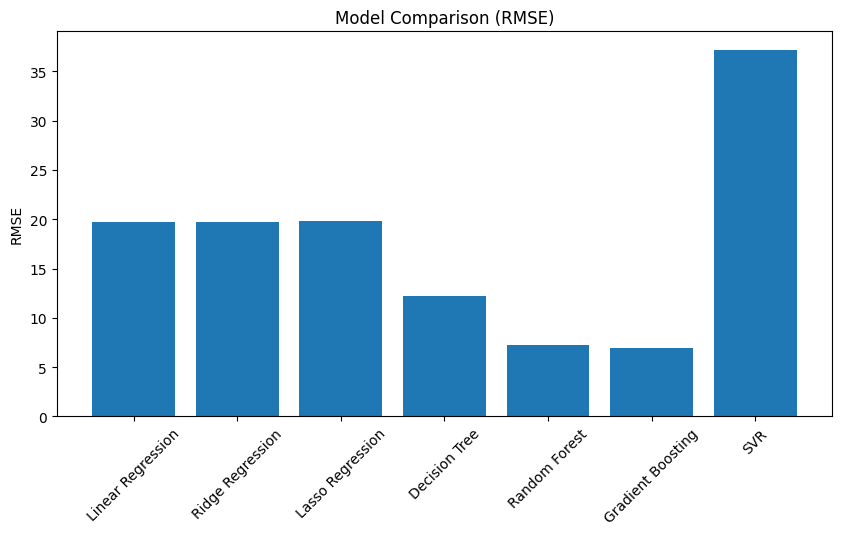

In [17]:
plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["RMSE"])
plt.xticks(rotation=45)
plt.ylabel("RMSE")
plt.title("Model Comparison (RMSE)")
plt.show()

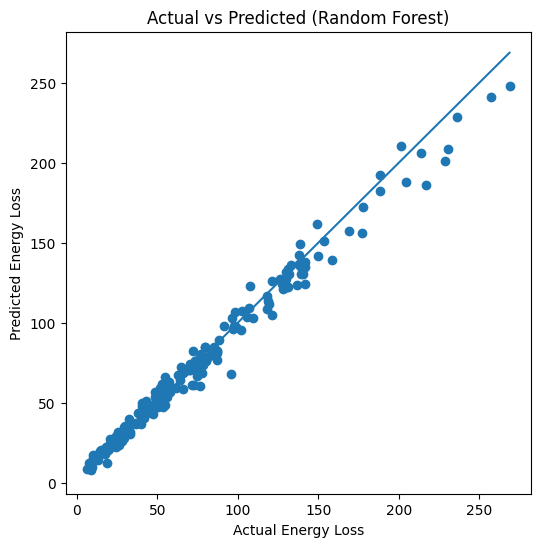

In [18]:
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds)
plt.xlabel("Actual Energy Loss")
plt.ylabel("Predicted Energy Loss")
plt.title("Actual vs Predicted (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()

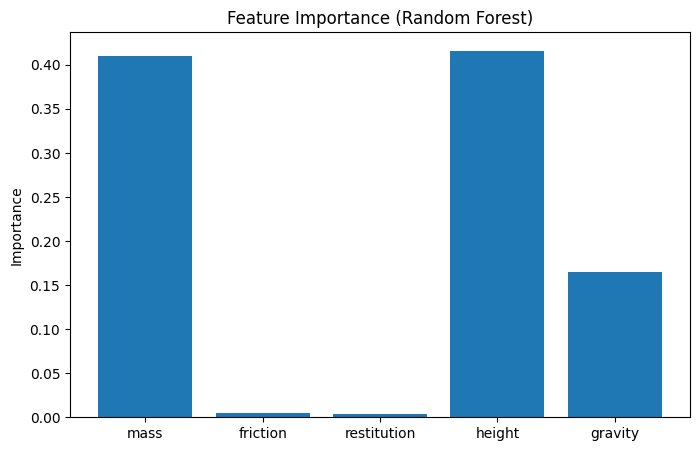

In [19]:
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.bar(features, importances)
plt.ylabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()